In [1]:
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    Trainer,
    TrainingArguments,
    pipeline,
)
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset
from peft import LoraConfig, TaskType, get_peft_model
import warnings

warnings.filterwarnings("ignore")

## Load dataset

In [2]:
dataset = load_dataset(
    "gretelai/symptom_to_diagnosis",
    data_files={"train": "train.jsonl", "test": "test.jsonl"},
)
dataset = dataset.rename_column("output_text", "label")

## Prepare tokenizer and Base LLM

In [3]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
sorted_labels = sorted(set(dataset["train"]["label"]))
label2id = dict(zip(sorted_labels, range(0, len(sorted_labels))))
id2label = dict(zip(range(0, len(sorted_labels)), sorted_labels))
base_llm = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=len(label2id), label2id=label2id, id2label=id2label
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Base model performance on test set

In [4]:
classifier = pipeline("text-classification", model=base_llm, tokenizer=tokenizer)
predicted_labels = classifier(dataset["test"]["input_text"])
test_array = np.asarray(dataset["test"]["label"])
pred_array = np.asarray([item["label"] for item in predicted_labels])

base_llm_accuracy = round(sum(test_array == pred_array) * 100 / len(test_array), 2)
print(f"Base LLM Model Accuracy: {base_llm_accuracy}%")

Base LLM Model Accuracy: 4.72%


## Tokenize Data

In [5]:
def preprocess_function(examples):
    tokens = tokenizer(examples["input_text"], padding="max_length", truncation=True)
    tokens["label"] = [label2id[l] for l in examples["label"]]
    return tokens


tokenized_ds = {
    split: dataset[split].map(preprocess_function, batched=True)
    for split in ["train", "test"]
}

## Finetune the model

In [6]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {"accuracy": (predictions == labels).mean() * 100}


training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=15,
    learning_rate=2e-3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    load_best_model_at_end=True,
)


r_values = [2, 4, 8, 16, 32, 64, 128, 256, 512]
train_losses, eval_accuracies, test_accuracies = [], [], []

# Main loop to vary r values
for r in r_values:
    lora_config = LoraConfig(task_type=TaskType.SEQ_CLS, r=r, lora_dropout=0.1)
    peft_model = get_peft_model(base_llm, lora_config)

    # print the total number of parameters and R
    print(f"R: {r}")
    peft_model.print_trainable_parameters()

    trainer = Trainer(
        model=peft_model,
        args=training_args,
        train_dataset=tokenized_ds["train"],
        eval_dataset=tokenized_ds["test"],
        tokenizer=tokenizer,
        data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
        compute_metrics=compute_metrics,
    )

    # Collect log history
    trainer.train()
    trainer.state.save_to_json(f"trainer_state_r_{r}.json")
    trainer_logs = trainer.state.log_history

    # Extract training losses and evaluation accuracies
    current_train_losses = [log["loss"] for log in trainer_logs if "loss" in log]
    current_eval_accuracies = [
        log["eval_accuracy"] for log in trainer_logs if "eval_accuracy" in log
    ]
    train_losses.append(current_train_losses)
    eval_accuracies.append(current_eval_accuracies)

    # Evaluate on test set
    test_metrics = trainer.evaluate()
    test_accuracies.append(test_metrics["eval_accuracy"])

R: 2
trainable params: 90,646 || all params: 109,589,804 || trainable%: 0.08271389918719081


Epoch,Training Loss,Validation Loss,Accuracy
1,3.115200,3.064910,8.018868
2,2.904900,2.613630,21.226415
3,2.369700,2.121150,25.471698
4,1.854800,1.594752,43.396226
5,1.420700,1.176316,59.905660
6,1.037200,1.048067,62.264151
7,0.747100,0.686852,78.301887
8,0.558900,0.503489,82.547170
9,0.438100,0.511950,84.905660
10,0.368900,0.407178,85.849057


R: 4
trainable params: 164,374 || all params: 109,663,532 || trainable%: 0.14988939075936383


Epoch,Training Loss,Validation Loss,Accuracy
1,3.115500,3.065002,8.018868
2,2.908500,2.623370,17.452830
3,2.391500,2.185868,29.245283
4,1.804900,1.521272,51.415094
5,1.286400,1.004487,66.037736
6,0.888600,0.901415,69.339623
7,0.652800,0.695314,78.773585
8,0.470600,0.467758,85.377358
9,0.353400,0.563301,80.660377
10,0.352400,0.447526,87.264151


R: 8
trainable params: 311,830 || all params: 109,810,988 || trainable%: 0.2839697608403268


Epoch,Training Loss,Validation Loss,Accuracy
1,3.115600,3.065628,7.547170
2,2.915200,2.660865,19.811321
3,2.397000,2.086625,28.773585
4,1.720200,1.419104,55.188679
5,1.176500,0.989343,66.981132
6,0.859000,0.816268,75.471698
7,0.582400,0.595138,79.716981
8,0.439900,0.419661,86.792453
9,0.385400,0.355310,88.207547
10,0.299500,0.519485,86.792453


R: 16
trainable params: 606,742 || all params: 110,105,900 || trainable%: 0.5510531224938899


Epoch,Training Loss,Validation Loss,Accuracy
1,3.115600,3.065715,8.018868
2,2.915900,2.655607,17.452830
3,2.393700,2.104407,29.716981
4,1.778000,1.458760,51.886792
5,1.221400,0.984782,66.037736
6,0.851100,0.713152,82.547170
7,0.598100,0.684338,78.773585
8,0.430700,0.578172,84.433962
9,0.320100,0.439843,86.320755
10,0.297600,0.391407,86.320755


R: 32
trainable params: 1,196,566 || all params: 110,695,724 || trainable%: 1.0809505162096416


Epoch,Training Loss,Validation Loss,Accuracy
1,3.115500,3.065645,8.018868
2,2.926800,2.644295,20.283019
3,2.421700,2.163726,26.886792
4,1.804000,1.488524,50.943396
5,1.214600,1.020979,60.849057
6,0.833400,0.757437,77.830189
7,0.601900,0.581255,82.547170
8,0.412600,0.389837,87.735849
9,0.318200,0.529436,84.905660
10,0.335800,0.487224,84.433962


R: 64
trainable params: 2,376,214 || all params: 111,875,372 || trainable%: 2.1239831050572953


Epoch,Training Loss,Validation Loss,Accuracy
1,3.115500,3.065824,8.018868
2,2.925500,2.656890,19.811321
3,2.406000,2.099340,29.245283
4,1.770900,1.410572,54.716981
5,1.203400,0.980755,63.207547
6,0.844000,0.881158,71.698113
7,0.607300,0.883174,71.698113
8,0.444000,0.311185,90.566038
9,0.319600,0.595153,79.716981
10,0.359100,0.399240,86.320755


R: 128
trainable params: 4,735,510 || all params: 114,234,668 || trainable%: 4.145422823831378


Epoch,Training Loss,Validation Loss,Accuracy
1,3.115600,3.066414,7.547170
2,2.923600,2.639826,19.339623
3,2.419000,2.035160,32.075472
4,1.787000,1.454366,49.528302
5,1.248900,1.022346,62.264151
6,0.882400,0.811178,76.415094
7,0.577100,0.706035,76.886792
8,0.426500,0.487872,89.622642
9,0.362700,0.601558,79.245283
10,0.264700,0.463046,86.320755


R: 256
trainable params: 9,454,102 || all params: 118,953,260 || trainable%: 7.947745190001518


Epoch,Training Loss,Validation Loss,Accuracy
1,3.115700,3.066897,7.547170
2,2.926900,2.665500,15.094340
3,2.414200,2.050372,31.132075
4,1.745700,1.424445,54.245283
5,1.202600,0.978727,69.811321
6,0.829900,0.694143,81.603774
7,0.560100,0.576522,80.660377
8,0.431900,0.606206,83.490566
9,0.391400,0.385015,91.509434
10,0.345500,0.702086,85.377358


R: 512
trainable params: 18,891,286 || all params: 128,390,444 || trainable%: 14.713934628966623


Epoch,Training Loss,Validation Loss,Accuracy
1,3.115900,3.068089,7.075472
2,2.935700,2.642440,17.452830
3,2.439900,2.129805,29.716981
4,1.784500,1.382917,56.603774
5,1.221300,0.945353,66.981132
6,0.864500,0.791499,76.415094
7,0.569300,0.773137,73.113208
8,0.434400,0.350307,87.264151
9,0.392400,0.556369,83.018868
10,0.299400,0.393567,87.264151


## Plots

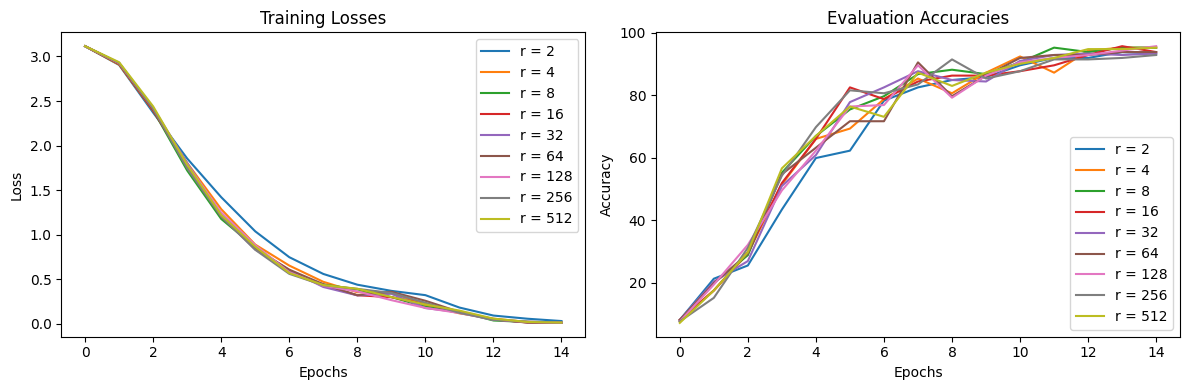

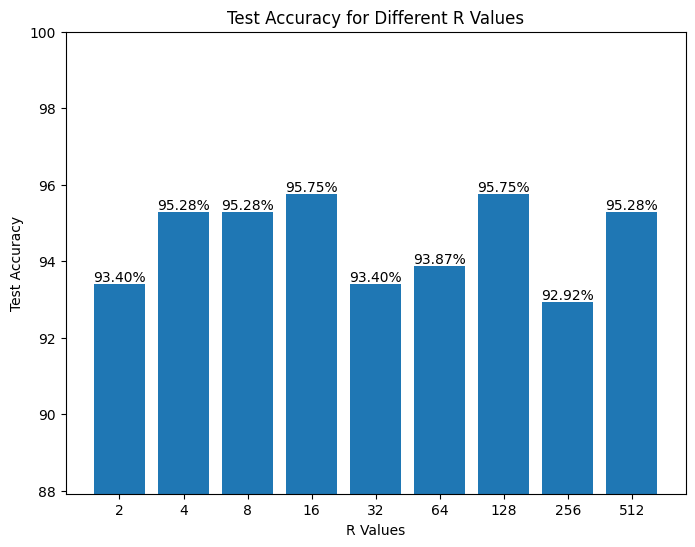

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
for i, r in enumerate(r_values):
    ax[0].plot(train_losses[i], label=f"r = {r}")
    ax[1].plot(eval_accuracies[i], label=f"r = {r}")
ax[0].set_title("Training Losses")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].legend()
ax[1].set_title("Evaluation Accuracies")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].legend()
plt.tight_layout()
plt.savefig("training_evaluation_metrics.png")
plt.show()

plt.figure(figsize=(8, 6))
r_values_str = [str(r) for r in r_values]
plt.bar(r_values_str, test_accuracies)
for i in range(len(r_values_str)):
    plt.text(
        i, test_accuracies[i], f"{test_accuracies[i]:.2f}%", ha="center", va="bottom"
    )
plt.ylim(min(test_accuracies) - 5, 100)
plt.xlabel("R Values")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy for Different R Values")
plt.savefig("test_accuracy.png")
plt.show()

## Comparison with Full Fine-tuning

In [6]:
# full fine-tuning the base LLM model without PEFT
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {"accuracy": (predictions == labels).mean() * 100}


training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=15,
    learning_rate=2e-3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=base_llm,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["test"],
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
)

trainer.train()
test_metrics = trainer.evaluate()
full_ft_base_llm_test_accuracy = test_metrics["eval_accuracy"]
print(f"Full Fine-Tuning Base LLM Test Accuracy: {full_ft_base_llm_test_accuracy:.2f}%")

Epoch,Training Loss,Validation Loss,Accuracy
1,2.647600,1.492131,61.792453
2,0.956800,1.225332,62.264151
3,1.170600,1.244650,61.320755
4,2.760300,3.308909,4.716981
5,3.352800,3.504841,4.716981
6,3.400900,3.287866,4.716981
7,3.376000,3.344642,4.716981
8,3.468000,3.218394,4.716981
9,3.308900,3.328566,4.716981
10,3.232700,3.132365,4.716981


Full Fine-Tuning Base LLM Test Accuracy: 62.26%


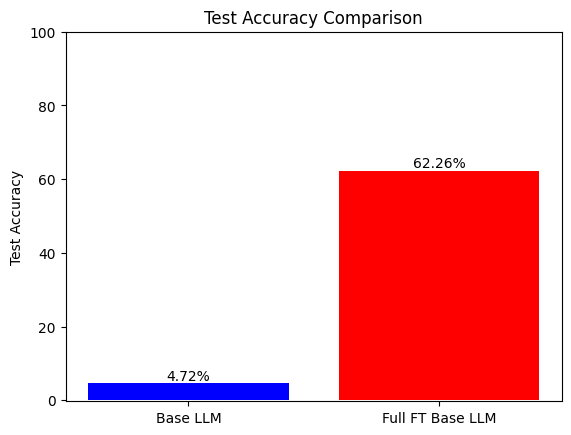

In [8]:
# plot the comparison of test accuracies
fig, ax = plt.subplots()
ax.bar(
    ["Base LLM", "Full FT Base LLM"],
    [base_llm_accuracy, full_ft_base_llm_test_accuracy],
    color=["blue", "red"],
)
for i in range(2):
    ax.text(
        i,
        [base_llm_accuracy, full_ft_base_llm_test_accuracy][i],
        f"{[base_llm_accuracy, full_ft_base_llm_test_accuracy][i]:.2f}%",
        ha="center",
        va="bottom",
    )
plt.ylim(min(base_llm_accuracy, full_ft_base_llm_test_accuracy) - 5, 100)
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy Comparison")
plt.savefig("test_accuracy_comparison.png")
plt.show()